# EigenFaces

Before we begin make sure you read the pdf document fully and that you did not change the order of folders or files. Keep the same order as in the zip file of HW3. For this assignment by the way, there is no need to divide the data into training and testing sets.

In [248]:
import numpy as np
import itertools
from tqdm import tqdm
import pickle
import sys
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
mpl.style.use(['ggplot']) 
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from IPython.display import display, clear_output

from PIL import Image
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA

We will start by loading a dataset of human faces out of `scikit-learn` datasets. If for some reason the next cell fails, you may activate the next one (which is now in comments). Make sure that the `X.npy` file is at the same location of this notebook.

In [251]:
# Load data
lfw_dataset = fetch_lfw_people(min_faces_per_person=0)
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data

y = lfw_dataset.target
target_names = lfw_dataset.target_names
target_names = target_names[y]
print("Dataset images are at the shape of {}X{}".format(h,w))

Dataset images are at the shape of 62X47


In [252]:
# X = np.load(''Data/X.npy')
# h = 62
# w = 47
# print("Dataset images are at the shape of {}X{}".format(h,w))

In [253]:
with open('Data/targets.pkl', 'rb') as f:
    y, target_names = pickle.load(f)

In [254]:
print(X.shape[0],len(target_names))

13233 13233


13,233 images were flattened and stacked in the matrix $X$ so every row is an image and every column is a pixel. We can see that by the shape of $X$.

In [255]:
print(X.shape)

(13233, 2914)


Let's see some of the images of the original dataset:

In [256]:
def plot_gallery(images,target_names, h, w,rows=3, cols=4):
    plt.figure(figsize=(14,14))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i, :].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(target_names[i])
        plt.xticks(())
        plt.yticks(())
    plt.show()

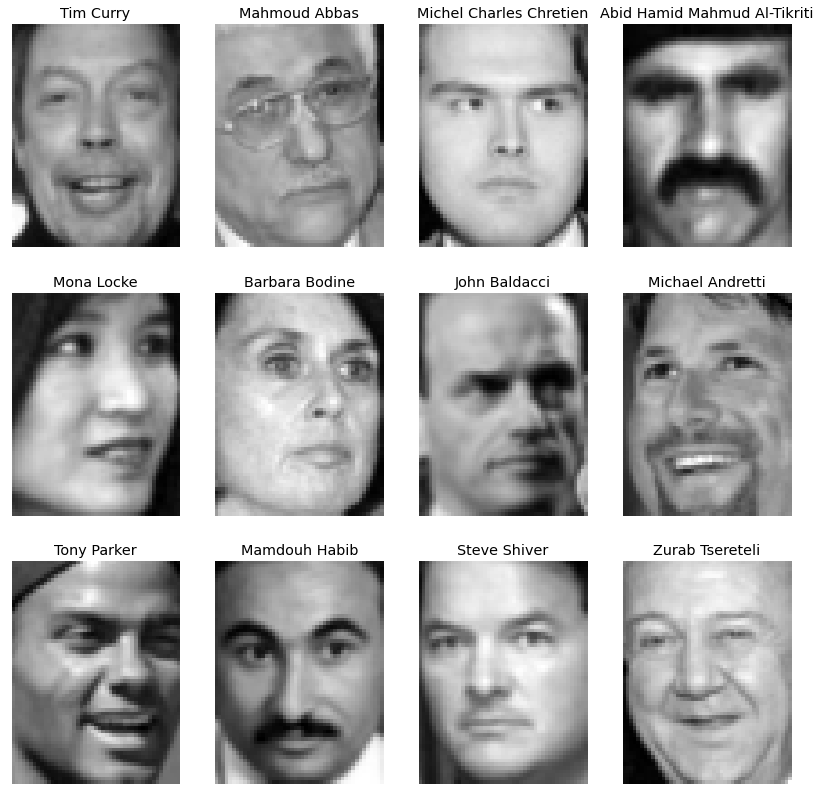

In [257]:
plot_gallery(X, target_names, h, w)

Before we use the `PCA` package, we have to center our data (even though `pca.fit_transform()` does it automatically, here we will do it for practicing). The center of our data ($\mu$) is the mean of each pixel along all of our images. Thus, the center has 2,914 elements where the first element is the mean of all of the images' "first" pixels, the second is the mean of all of the images' "second" pixels etc. Notice that the images are already flattened in $X$ which might help you.

Name your `pca` object: `pca`.

Calculate $\mu$ of $X$ and center every image in $X$ (row vector) according to $\mu$. Keep $X$ with same name `X`. Name the $\mu$ vector `mu_orig`.

If you can, apply centering without a single loop.

In [258]:
#----------------------------Implement your code here-----------------------
mu_orig=np.mean(X,axis=0)
ones = np.ones((X.shape[0],1))
X = X - ones*mu_orig
#---------------------------------------------------------------------------

Now fit a PCA model on $X$ (**without whitening**) that would preserve 99.5% of the energy. Find out how many eigenvectors you remained with and set it as $K$.

In [259]:
#----------------------------Implement your code here-----------------------
pca=PCA(n_components=0.995, svd_solver='full')
X_pca=pca.fit_transform(X)
eigenvalues = pca.explained_variance_
K=len(eigenvalues)
print(K)
#---------------------------------------------------------------------------

734


---

<span style="color:red">***Question:***</span> *If we now have $K$ eigenvectors, by how many dimensions we have reduced our data?*

---

---

<span style="color:red">***Answer:***</span> 
the number of eign values is the number of dimensions after pca 
The dimension for each image is 2914 so dimension were reduced by 2914-K

---

Let's see these eigenfaces!

In [260]:
def plot_eigenfaces(eigenvec_mat, h, w, rows=3, cols=4):
    plt.figure(figsize=(10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(eigenvec_mat[i, :].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("$u_{" + str(i+1) + "}$")
        plt.xticks(())
        plt.yticks(())
    plt.show()

`eigenvec_mat` is the matrix of the eigenvectors calculated where every row is an eigenvector and the first row has the highest eigenvalue and the second row has the next highest eigenvalue etc. Think where this matrix was calculated in the process.

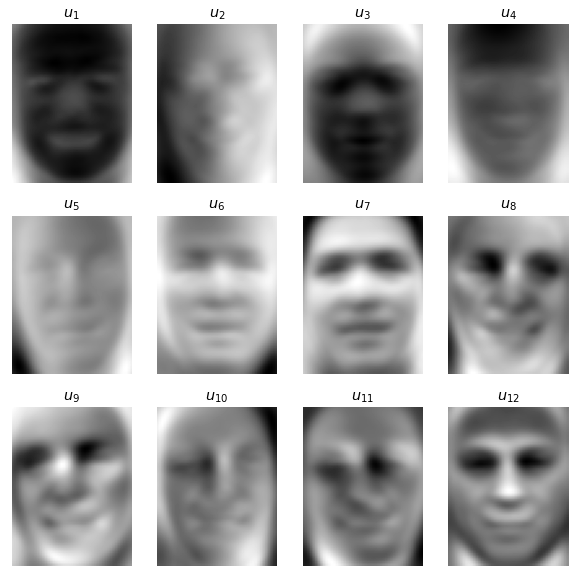

In [261]:
eigenvec_mat = pca.components_
plot_eigenfaces(eigenvec_mat, h, w)

If you got it right, you should see those "ghosts" we talked about.

And now, let's move on towards the more interesting part! We will start by showing your resized gray level face image. It might be a bit distorted due to resizing. Change the format of `.jpg` as needed.

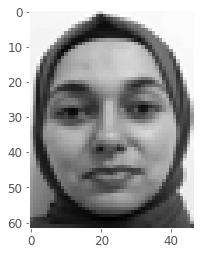

In [262]:
img_format = '.jpg' # change the format according to your image. Do not delete the dot sign before the format name
image = Image.open('Data/Orig' + img_format)

gray = image.convert('L')
g = gray.resize((w, h))
orig = np.asarray(g).astype('float32')
plt.imshow(orig, cmap=plt.cm.gray)
plt.grid(False)

Now we should flatten our image and center it by the same $\mu$ vector you calculated before.

In [263]:
flattened_img = np.asarray(g).astype('float32').flatten()
flattened_img -= mu_orig

Define `U` to be the matrix containing the first K eigenvectors (rows) extracted from `eigenvec_mat`. Now, calculate the projections $c_i$ so you would have a vector with $K$ elements where the first element is $c_1$ and the second is $c_2$ etc. Relate to the pdf if you are not sure. **Note:** you can only use `U`, your flattened imgae and `numpy` for this section. **Do not apply `pca` methods for calculating the projections.**

In [264]:
#----------------------------Implement your code here-----------------------
U = eigenvec_mat[:K,]
c = np.matmul(U, flattened_img)
print(c.shape)
#--------------------------------------------------------------------------

(734,)


If you got it all correct, then the cell below will show you how your face is reconstructed as a linear combination of the eigenfaces which actually means that your face is a linear combination of other people's faces! The coefficients will appear with their adequate sign in the title in the left and the image constructed will appear slowly on the right.

Notice the "correction" of the centering made in the loop for visualization.


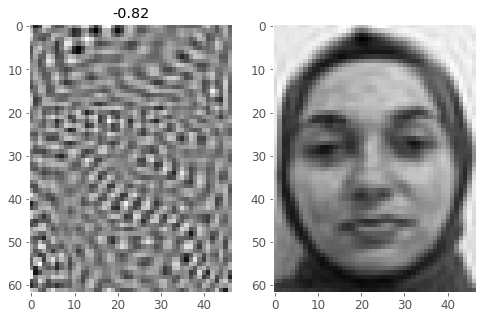

In [265]:
s = np.zeros((h*w,))
fig, axes = plt.subplots(1, 2,figsize=(8,8))
for j in range(K):
    s += c[j]*U[j, :]
    if np.mod(j, 10) == 0:
        axes[0].imshow(U[j, :].reshape((h, w)), cmap=plt.cm.gray)
        axes[0].grid(False)
        corrected_image = s + mu_orig
        axes[1].imshow(corrected_image.reshape((h, w)), cmap=plt.cm.gray)
        axes[1].grid(False)
        if c[j] < 0:
            axes[0].set_title('{:.2f}'.format(c[j]))
        else:
            axes[0].set_title('+{:.2f}'.format(c[j]))
        display(fig)
        clear_output(wait = True)
        plt.pause(0.3)
        if c[j] > 0:
            p = '+' + str(c[j])
        else:
            p = str(c[j])

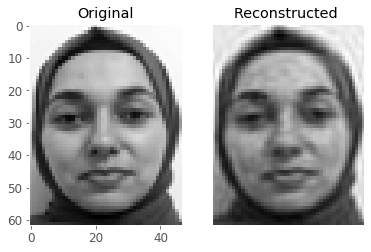

In [266]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(orig, cmap=plt.cm.gray) 
axes[0].title.set_text('Original')
axes[0].grid(False)
plt.xticks(())
plt.yticks(())
axes[1].imshow(corrected_image.reshape((h, w)), cmap=plt.cm.gray)
axes[1].title.set_text('Reconstructed ')
axes[1].grid(False)
plt.xticks(())
plt.yticks(())
plt.show()

Hopefully, you got a nice reconstruction from those "ghosts". Now, we will continue to the face recgonition part. 

Facebook has also learned the natural basis of human faces using a database of different faces much like you did here. Now, some of your images are tagged (labeled) in a larger (mostly different) database with your name. It then projects the images on the PCA axes and gets an "id" ($c$ coefficients) for each and every image in the tagged database. When someone uploades a picture without tagging, Facebook uses the same learned PCA in order to create this new image an id . and then looks through the tagged id database for comparison. The closest match (user) will get a notification whether or not he\she would like to be tagged according to the match.

We will make a simple simulation. First we will create a tagged database, which in our case will simply be `X` concatenated with your "Orig" flattened and centered image. We will call it `X_new`.

In [267]:
X_new = X.copy()
X_new = np.vstack([X_new, flattened_img])
X_new.shape

(13234, 2914)

Notice that the number of rows was increased by 1 accordingly. Now we will add your name. Fill your name as a string below:

In [268]:
name = 'Reem'
target_new = target_names.copy()
target_new = np.append(target_names, name)
target_new.shape

(13234,)

Let's shuffle the databse:

In [269]:
from sklearn.utils import shuffle
X_new, y_new = shuffle(X_new, target_new, random_state=0)

Now let's simulate a new uploaded untagged (out of the database) image and show it. You can use either "tilt1" or "tilt2". Then we will also center it.

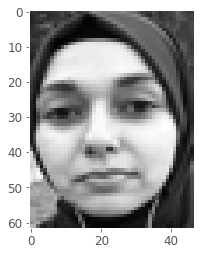

In [299]:
img_format = '.jpeg' # change the format according to your image. Do not delete the dot sign before the format name
image = Image.open('Data/tilt1' + img_format)  #change the name if needed
gray = image.convert('L')
g = gray.resize((w, h))
new_input = np.asarray(g).astype('float32')
plt.imshow(new_input, cmap=plt.cm.gray)
plt.grid(False)

In [300]:
flattened_img_new = np.asarray(g).astype('float32').flatten()
flattened_img_new -= mu_orig

In [301]:
print(flattened_img_new.shape)

(2914,)


And now for the recognition part:
First, project the new database onto the **already fitted** PCA basis. You can use `pca` methods. Then calculate the projections (`c` vector) for the new input similarly to what you did before. Then run in a for loop and measure the Euclidean distance between the new output projection to each and everyone of the projections of the new database. Finally return the index (row number) of the best matching image in the database (minimal distance) and name it as `idx_match`.

In [296]:
# #----------------------------Implement your code here-----------------------
projection=pca.transform(X_new)
print(projection.shape)
c = np.matmul(U,flattened_img_new)
print(c.shape)
distance_list=[]
for i in range(c.shape[0]):
  distance_list.append(np.linalg.norm(projection[i,:]-c))
idx_match = np.argmin(distance_list)
print("idx_match = "+str(idx_match))
##-----------------------------------


(13234, 734)
(734,)
idx_match = 700


Let's see if you got it right. If so, on left image you would see your tilted untagged image and on the right the best matching image of the database.

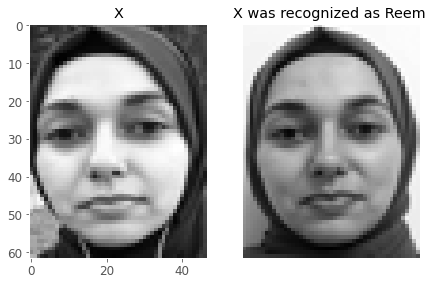

In [302]:
fig, axes = plt.subplots(1, 2, figsize=(7,7))
axes[0].imshow(new_input, cmap=plt.cm.gray) 
axes[0].title.set_text('X')
axes[0].grid(False)
plt.xticks(())
plt.yticks(())
axes[1].imshow((X_new[idx_match, :] + mu_orig).reshape((62, 47)), cmap=plt.cm.gray)
axes[1].title.set_text('X was recognized as {} '.format(y_new[idx_match]))
axes[1].grid(False)
plt.xticks(())
plt.yticks(())
plt.show()

The power of PCA is the ability to find your image across 13,324 images with using only Euclidien distance of $K$ elements vectors rather using image matching techniques involving higher dimensional data, computational power and mostly morphlogical priors and filters! Try it also for the second image and check if it worked.

Notice that even if it failed to recognize you but the code was correct, you will get the full credit points for this section.

Hope you enjoyed :)

**Note:** Basically, once you run all of the Jupyter cells and save the file, then it would be saved with all of your outputs. Thus, only the pdf with your answers for the theoretical part and the notebook with the outputs should be uploaded to GitHub without your personal jpg images.